<a id="start"></a>
# Исследование каналов привлечения клиентов Procrastinate Pro+

### Описание проекта
Мы проводим исследование развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

#### Цель исследования
Наша задача — разобраться в причинах убытков компании и помочь ей выйти в плюс.

#### План работы

1. [Загрузим данные и подготовим их к анализу.](#load_data)
2. [Проведем исследовательский анализ данных.](#analisys)
3. [Исследуем расходы на маркетинг.](#market)
4. [Оценим окупаемость рекламы.](#advertising)
5. [Напишем выводы.](#conclusion)

### Описание данных
В нашем распоряжении три датасета о пользователях, привлечённых с 1 мая по 27 октября 2019 года. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Файл `visits_info_short.csv`:<br>
- `User Id` - уникальный идентификатор пользователя,
- `Region` - страна пользователя,
- `Device` - тип устройства пользователя,
- `Channel` - идентификатор источника перехода,
- `Session Start` - дата и время начала сессии,
- `Session End` - дата и время окончания сессии.

Файл `orders_info_short.csv`:<br>
- `User Id` - уникальный идентификатор пользователя,
- `Event Dt` - дата и время покупки,
- `Revenue` - сумма заказа.

Файл `costs_info_short.csv`:<br>
- `dt` - уникальный идентификатор пользователя,
- `Channel` - дата и время покупки,
- `costs` - сумма заказа.

<a id="load_data"></a>
### Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import seaborn as sns
from utils import (get_profiles, 
                   get_retention, 
                   get_conversion, 
                   get_ltv, 
                   filter_data, 
                   plot_retention, 
                   plot_conversion, 
                   plot_ltv_roi)

In [2]:
sessions = pd.read_csv('data/visits_info_short.csv')
orders = pd.read_csv('data/orders_info_short.csv')
costs = pd.read_csv('data/costs_info_short.csv')

#### Посмотрим на данные

##### Таблица Визитов

In [3]:
sessions.sample(5)

User Id         Region  Device   Channel        Session Start  \
70677   160487475175  United States  iPhone   organic  2019-07-09 04:08:38   
248695  383236954765             UK     Mac   LeapBob  2019-07-22 18:41:31   
163370  803309057504  United States  iPhone  FaceBoom  2019-09-28 04:53:57   
68109   971284236917  United States     Mac   organic  2019-07-07 17:59:07   
200     327927279217  United States     Mac   organic  2019-05-01 19:19:36   

                Session End  
70677   2019-07-09 04:26:47  
248695  2019-07-22 18:58:24  
163370  2019-09-28 05:21:19  
68109   2019-07-07 18:00:38  
200     2019-05-01 19:22:14

##### Переименуем наши столбцы, так чтобы они соотвествовали snake_style

In [4]:
sessions.columns = ('_'.join(col.lower().split()) for col in list(sessions.columns))

##### Взглянем на уникальные значения в столбцах `region`, `device`, `channel`.

In [5]:
def value_counts(data: pd.DataFrame, column: str) -> None:
    """
    Выводит частоты значений столбцов.
    """
    print(f'Частота встречаемых значений - {column}')
    print('-' * 37)
    display(
        data[column].value_counts().reset_index().rename(columns={'index': 'value'})
    )
    print()

In [6]:
for column in ('region', 'device', 'channel'):
    value_counts(sessions, column)

Частота встречаемых значений - region
-------------------------------------


region   count
0  United States  207327
1             UK   36419
2         France   35396
3        Germany   30759


Частота встречаемых значений - device
-------------------------------------


device   count
0   iPhone  112603
1  Android   72590
2       PC   62686
3      Mac   62022


Частота встречаемых значений - channel
-------------------------------------


channel   count
0              organic  107760
1               TipTop   54794
2             FaceBoom   49022
3       WahooNetBanner   20465
4              LeapBob   17013
5   OppleCreativeMedia   16794
6       RocketSuperAds   12724
7              YRabbit    9053
8         MediaTornado    8878
9           AdNonSense    6891
10      lambdaMediaAds    6507

##### Посмотрим на минимальные и максимальные значения `session_start`, `session_end`.

In [7]:
def min_max(data: pd.DataFrame, columns: list[str]) -> None:
    """
    Показывает максимальные и минимальные значения в столбцах.
    """
    print(f'Максимальная и минимальная дата в {", ".join(columns)}')
    dic = {col_name: [] for col_name in ('Минимальная дата', 'Максимальная дата')}
    for column in columns:
        dic['Минимальная дата'].append(data[column].min())
        dic['Максимальная дата'].append(data[column].max())
    display(pd.DataFrame(dic, index=columns))

In [8]:
min_max(sessions, ['session_start', 'session_end'])

Максимальная и минимальная дата в session_start, session_end


Минимальная дата    Максимальная дата
session_start  2019-05-01 00:00:41  2019-10-31 23:59:23
session_end    2019-05-01 00:07:06  2019-11-01 01:38:46

Аномальных значений в таблице визитов не обнаружено.

##### Таблица заказов

In [9]:
orders.sample(5)

User Id             Event Dt  Revenue
24342  332268843042  2019-10-15 07:16:50     4.99
1062   872148430066  2019-05-20 13:44:52     4.99
37486  133433617308  2019-10-04 14:16:54     4.99
34443  984810919755  2019-08-31 22:56:05     4.99
14728  776599012473  2019-08-28 00:52:22     4.99

##### Переименуем столбцы

In [10]:
orders.columns = ('_'.join(col.lower().split()) for col in list(orders.columns))

##### Посмотрим на уникальные значения стобца `Revenue`.

In [11]:
value_counts(orders, 'revenue')

Частота встречаемых значений - revenue
-------------------------------------


revenue  count
0     4.99  38631
1     5.99    780
2     9.99    385
3    49.99    212
4    19.99    204

##### Посмотрим на минимальные и максимальные значения `event_dt`.

In [12]:
min_max(orders, ['event_dt'])

Максимальная и минимальная дата в event_dt


Минимальная дата    Максимальная дата
event_dt  2019-05-01 00:28:11  2019-10-31 23:56:56

Аномальных значений в таблице заказов не обнаружено.

In [13]:
costs.sample(5)

dt             Channel  costs
1404  2019-09-22  OppleCreativeMedia  18.00
1160  2019-07-20             LeapBob   6.72
1486  2019-06-16      WahooNetBanner  33.60
1026  2019-09-04          AdNonSense  12.60
1740  2019-08-29      lambdaMediaAds   5.60

##### Также приведем столбцы к змеиному стилю

In [14]:
costs.columns = ('_'.join(col.lower().split()) for col in list(costs.columns))

#### Посмотрим на уникальные значения в столбце `channel`.

In [15]:
value_counts(costs, 'channel')

Частота встречаемых значений - channel
-------------------------------------


channel  count
0            FaceBoom    180
1        MediaTornado    180
2      RocketSuperAds    180
3              TipTop    180
4             YRabbit    180
5          AdNonSense    180
6             LeapBob    180
7  OppleCreativeMedia    180
8      WahooNetBanner    180
9      lambdaMediaAds    180

Судя по всему мы каждый день используем все 10 каналов привлечения пользователей.

##### Посмотрим минимальные и максимальные значения в столбце `dt`.

In [16]:
min_max(costs, ['dt'])

Максимальная и минимальная дата в dt


Минимальная дата Максимальная дата
dt       2019-05-01        2019-10-27

##### Посмотрим на распределение значения переменной `costs`.

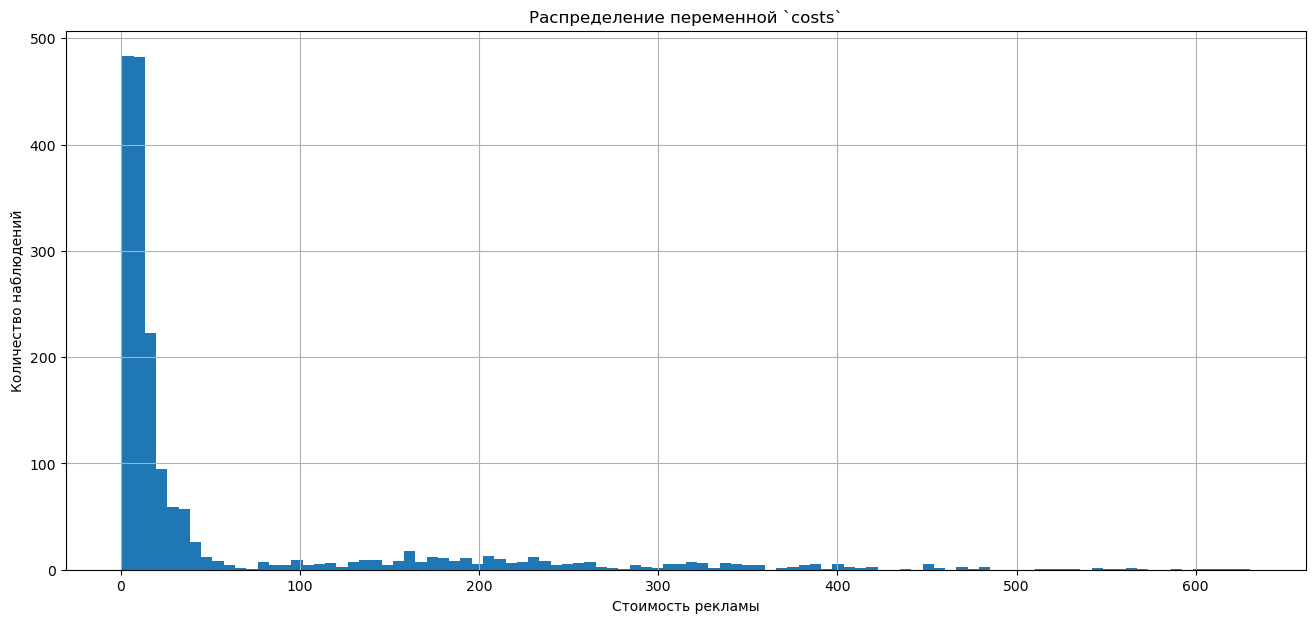

In [17]:
costs.costs.hist(bins=100, figsize=[16, 7])
plt.title('Распределение переменной `costs`')
plt.xlabel('Стоимость рекламы')
plt.ylabel('Количество наблюдений')
plt.show()

Аномальных значений в таблице расходов не обнаружено.

#### Посмотрим количество пропущенных значений и типы данных.

In [18]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [20]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропущенные значения отсутствуют, но переменные, которые содержат данные о времени(`session_start`, `session_end`, `event_dt`, `dt`) имеют тип данных object. Изменим их на datetime.

In [21]:
for session in ('session_start', 'session_end'):
    sessions[session] = pd.to_datetime(sessions[session])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

#### Теперь проверим данные на дубликаты

##### В таблице sessions, дубликатами будем считать строки имеющие одинаковые идентификатор пользователя и время начала сессии

In [22]:
dupl = sessions[sessions.duplicated(subset=('user_id', 'session_start'))].size
print(f'Количество дубликатов в таблице visits - {dupl}')

Количество дубликатов в таблице visits - 0


##### В таблице orders и costs дубликатами будем считать полностью одинаковые строки 

In [23]:
print(f'Количество дубликатов в таблице orders - {orders[orders.duplicated()].size}')

Количество дубликатов в таблице orders - 0


In [24]:
print(f'Количество дубликатов в таблице costs - {costs[costs.duplicated()].size}')

Количество дубликатов в таблице costs - 0


#### Вывод по обработке данных:
- Пропущенные значения в таблицах отсутствуют.<br>
- Столбцы содержащие дату, были приведены к типу datetime.<br>
- Аномальных значений в данных не обнаружено.<br>
- Каждый день наш сервис использует все 10 каналов привлечения.<br>
- Дубликаты не обнаружены.

<a id="analisys"></a>
### Проведем сследовательский анализ данных

#### Создадим профили пользователей и определим минимальную и максимальную даты привлечения пользователей.

In [25]:
profiles = get_profiles(sessions, orders, costs)

In [26]:
profiles.head(5)

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [27]:
first_date = profiles['dt'].min()
last_date = profiles['dt'].max()
print(f'Минимальная дата привлечения пользователей - {first_date}')
print(f'Максимальная дата привлечения пользователей - {last_date}')

Минимальная дата привлечения пользователей - 2019-05-01
Максимальная дата привлечения пользователей - 2019-10-27


Даты совпадают с техническим заданием.

#### Выясним с каких стран пользователи приходят в наше приложение и на какую страну прихоится больше всего платящих пользователей, а также посмотрим доли платящих пользователей для каждой страны.

In [28]:
def calc_pivot_table(profiles: pd.DataFrame, column: str, alias: str) -> None:
    df = (
        profiles.groupby(column)
        .agg({'user_id':'nunique'})
        .rename(columns={'user_id': 'Количество пользователей'})
    )

    paying_users = (
        profiles[profiles.payer == True]
        .groupby(column)
        .user_id.nunique()
    )

    df['Количество платящих пользователей'] = df.index.map(paying_users)
    df['Доля платящих пользователей'] = (
        df['Количество платящих пользователей'] /
        df['Количество пользователей']
    )
    df.rename_axis(alias, inplace=True)

    display(df.sort_values(by='Доля платящих пользователей', ascending=False)
    .style.format(
        "{:.2%}", 
        subset='Доля платящих пользователей'
    ).background_gradient(
        cmap='Reds',  
        axis=0
    ))

In [29]:
calc_pivot_table(profiles, 'region', 'Страна')

К нам в сервис приходят из четырех стран - США, Великобритания, Франция и Германия. Безусловным лидером по общему количеству пользователей, количеству платящих пользователей, а также доли платящих пользователей является США.

#### Узнаем какими устройствами пользуются наши клиенты и какими устройствами предпочитают пользоваться платящие клиенты.

In [30]:
calc_pivot_table(profiles, 'device', 'Тип устройства')

Наши клиенты пользуются - IPhone, устройствами на ОС Android, PC и устройствами на операционной системе Mac. По общему количеству пользователей, а также по количеству платящих пользователей лидирует Iphone. Доля платящих пользователей самая высокая у устройств на базе Mac, IPhone занимает второе место.

#### Определим рекламные источники привлечения, выявим лидеров по количеству платящих пользователей среди каналов привлечения пользователей.

In [31]:
calc_pivot_table(profiles, 'channel', 'Источник рекламы')

У нас имеется 10 платных источников привлечения клиентов. Большая часть общего количества пользователей у нас пришли бесплатно.У этой группы доля платящих мала, но они нам достались бесплатно. Лидером по количеству платящих пользователей и по доле платящих пользователей является FaceBoom. 

#### Вывод по исследовательскому анализу:
- Большая часть наших пользователей живет в США.
- США является лидером по доле платящих пользователей и абсолютному количеству платящих пользователей среди других стран.
- Самым популярным устройством среди всех пользователей, а также платящих пользователей является IPhone.
- Доля платящих пользователей выше всего у пользующихся операционной системой Mac.
- Источники которые привлекают больше всего платящих пользователей - FaceBoom,
Tip Top.
- FaceBoom имеет самую высокую долю платящих клиентов среди общего количества клиентов.

<a id="market"></a>
### Исследование маркетинга

#### Посчитаем общую сумму расходов на маркетинг.

In [32]:
costs.costs.sum()
print(
    f'Общая сумма расходов на маркетинг,' 
    f'за исследуемый период - {costs.costs.sum():.2f}'
)

Общая сумма расходов на маркетинг,за исследуемый период - 105497.30


#### Посмотрим распределение трат по источникам

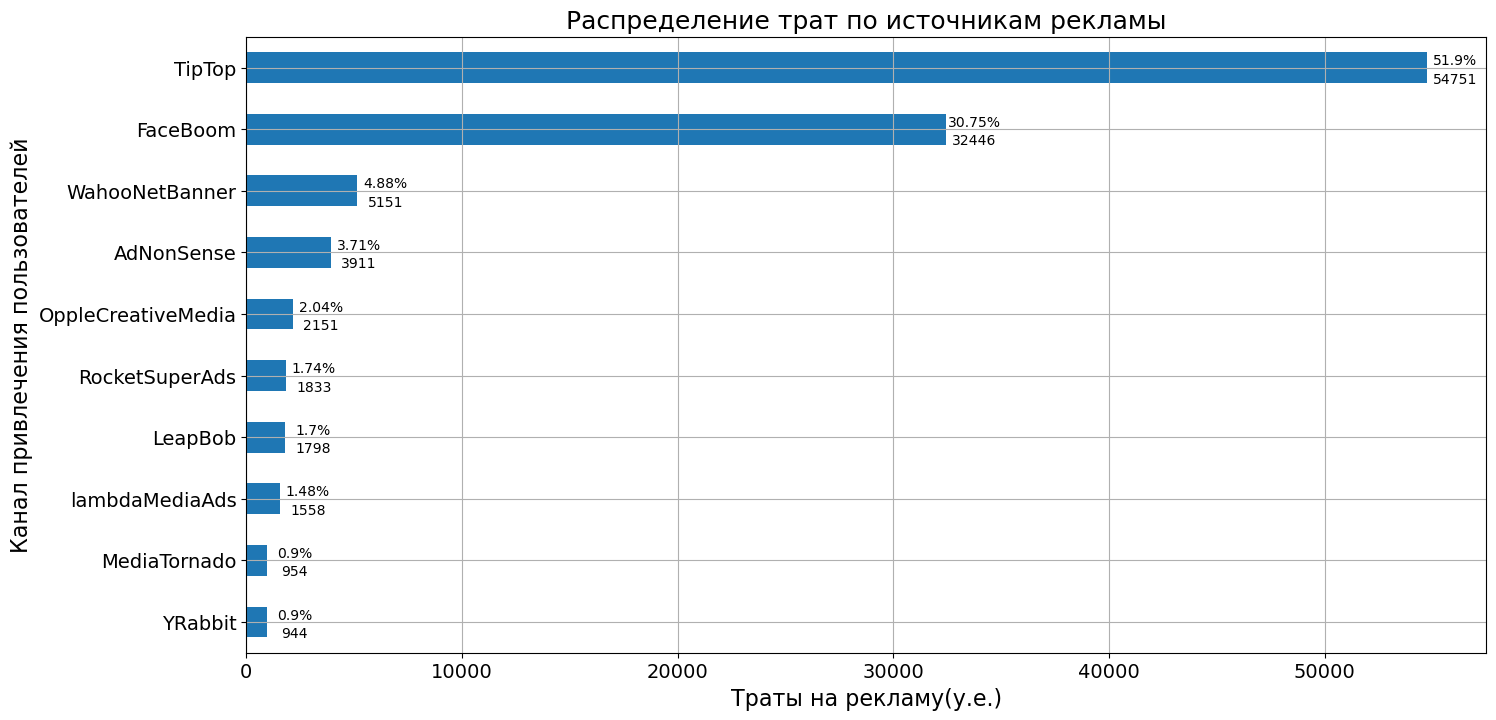

In [33]:
data = costs.groupby('channel').costs.sum().sort_values(ascending=True)
total_costs = data.sum()
data.plot(
    kind='barh',
    figsize=(16,8),
    grid=True,
    fontsize=14,  
)
for i, val in enumerate(data.values):
    plt.text(val + 1300, i - 0.3, str(round(float(val))), 
             horizontalalignment='center', 
             verticalalignment='bottom', 
             fontdict={'fontweight':500, 'size':10, 'color': 'black'})
    plt.text(val + 1300, i, str(round(float(val) / total_costs * 100, 2)) + '%', 
             horizontalalignment='center', 
             verticalalignment='bottom', 
             fontdict={'fontweight':500, 'size':10, 'color': 'black'})
plt.title('Распределение трат по источникам рекламы', fontsize=18)
plt.xlabel('Траты на рекламу(у.е.)', fontsize=16)
plt.ylabel('Канал привлечения пользователей', fontsize=16)
plt.show()

Расходы на TipTop практически в два раза превышают расходы на FaceBoom, причем платящих пользователей из канала TipTop в два раза меньше, чем из канала FaceBoom.

#### Посмотрим расходы на рекламу, по каждому каналу, в динамике.

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

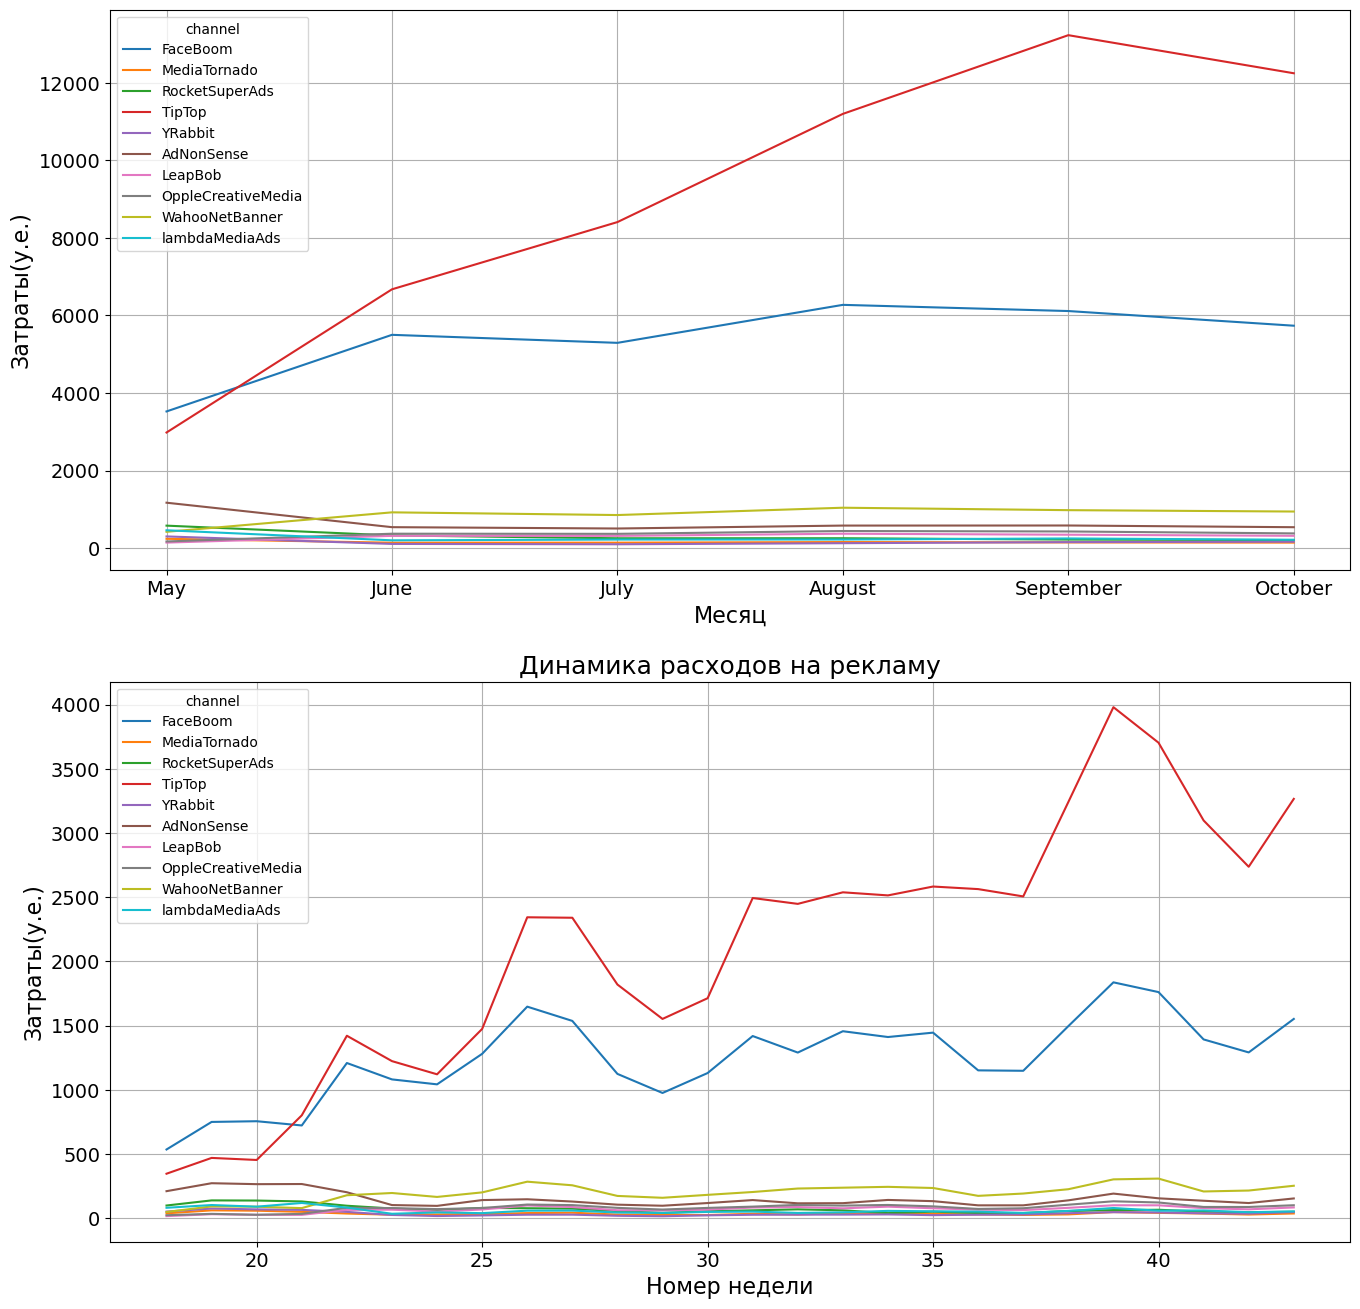

In [34]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month_name()

data_week = costs.groupby('week').agg({'costs': 'sum'})
data_month = costs.groupby('month').agg({'costs': 'sum'})


def plot_dinamic(data: pd.DataFrame, columns: str, alias: str, loc) -> None:
    ax = sns.lineplot(
        data=data, 
        x=columns, 
        y='costs', 
        hue='channel',
        estimator='sum', 
        errorbar=None,
        ax=plt.subplot(2, 1, loc)
    )
    
    plt.xlabel(alias, fontsize=16)
    plt.ylabel('Затраты(у.е.)', fontsize=16)
    plt.grid()
    plt.tick_params(labelsize=14)


plt.figure(figsize=(16, 16))
plot_dinamic(costs, 'month', 'Месяц', 1)
plot_dinamic(costs, 'week', 'Номер недели', 2)
plt.title('Динамика расходов на рекламу', fontsize=18)
plt.show()

Расходы по каналу TipTop выросли более чем в 6 раз, по каналу FaceBoom в 3 раза. По этим двум каналам мы можем наблюдать сильные всплески, чтобы их понять нужно пообщаться с маркетологами. Расходы на остальные каналы сильно не изменились.

#### Узнаем сколько в среднем стоило привлечение одного пользователя по каждому каналу.

In [35]:
profiles[profiles.channel != 'organic'].acquisition_cost.mean()

1.1274813239427588

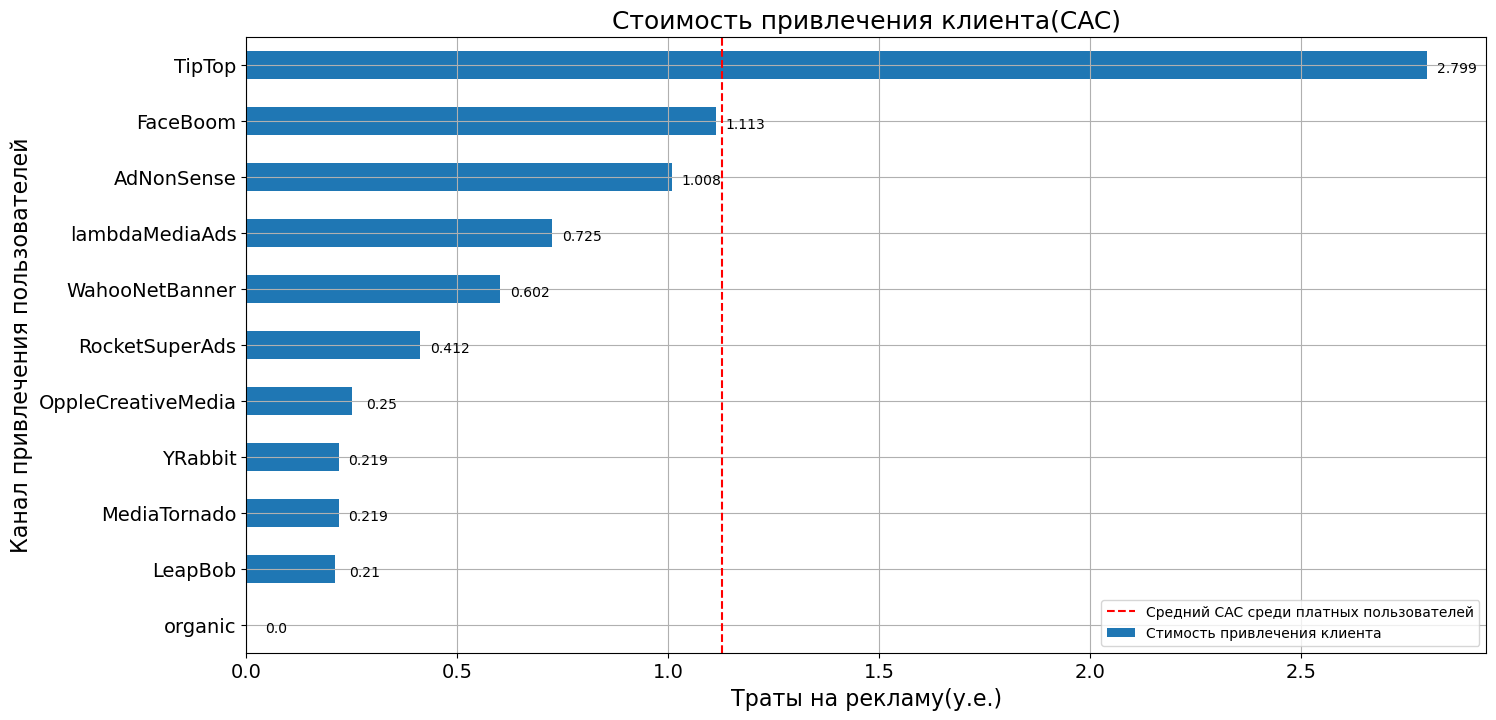

In [36]:
cost_per_user = profiles.groupby('channel').acquisition_cost.mean().sort_values()
# расчитаем средний CAC среди платных каналов.
mean_cost_per_user = profiles[profiles.channel != 'organic'].acquisition_cost.mean()
cost_per_user.plot(
    kind='barh',
    figsize=(16,8),
    grid=True,
    fontsize=14
)

for i, val in enumerate(cost_per_user.values):
    plt.text(val + 0.07, i - 0.19, str(round(float(val), 3)), 
             horizontalalignment='center', 
             verticalalignment='bottom', 
             fontdict={'fontweight':500, 'size':10, 'color': 'black'})

plt.axvline(x=mean_cost_per_user, ls='--', color='red', label='Средний CAC среди платных пользователей')

plt.title('Cтоимость привлечения клиента(CAC)', fontsize=18)
plt.xlabel('Траты на рекламу(у.е.)', fontsize=16)
plt.ylabel('Канал привлечения пользователей', fontsize=16)
plt.legend(['Средний CAC среди платных пользователей', 'Стимость привлечения клиента'],loc='lower right')
plt.show()

Канал TipTop очень дорого обходится для нашего приложения. Стоит исследовать окупаемость рекламы.

#### Вывод по исследованию маркетинга
- Общая сумма расходов на рекламу более 100 тыс. у.е.
- Расходы на два рекламных канала(TipTop, FaceBoom), выросли в несколько раз.
- Средняя стоимость привлечения одного клиента у TipTop очень высока и первышает FaceBoom более чем в два раза.

<a id="advertising"></a>
### Оценим окупаемость рекламы

#### Проанализируем окупаемость рекламы

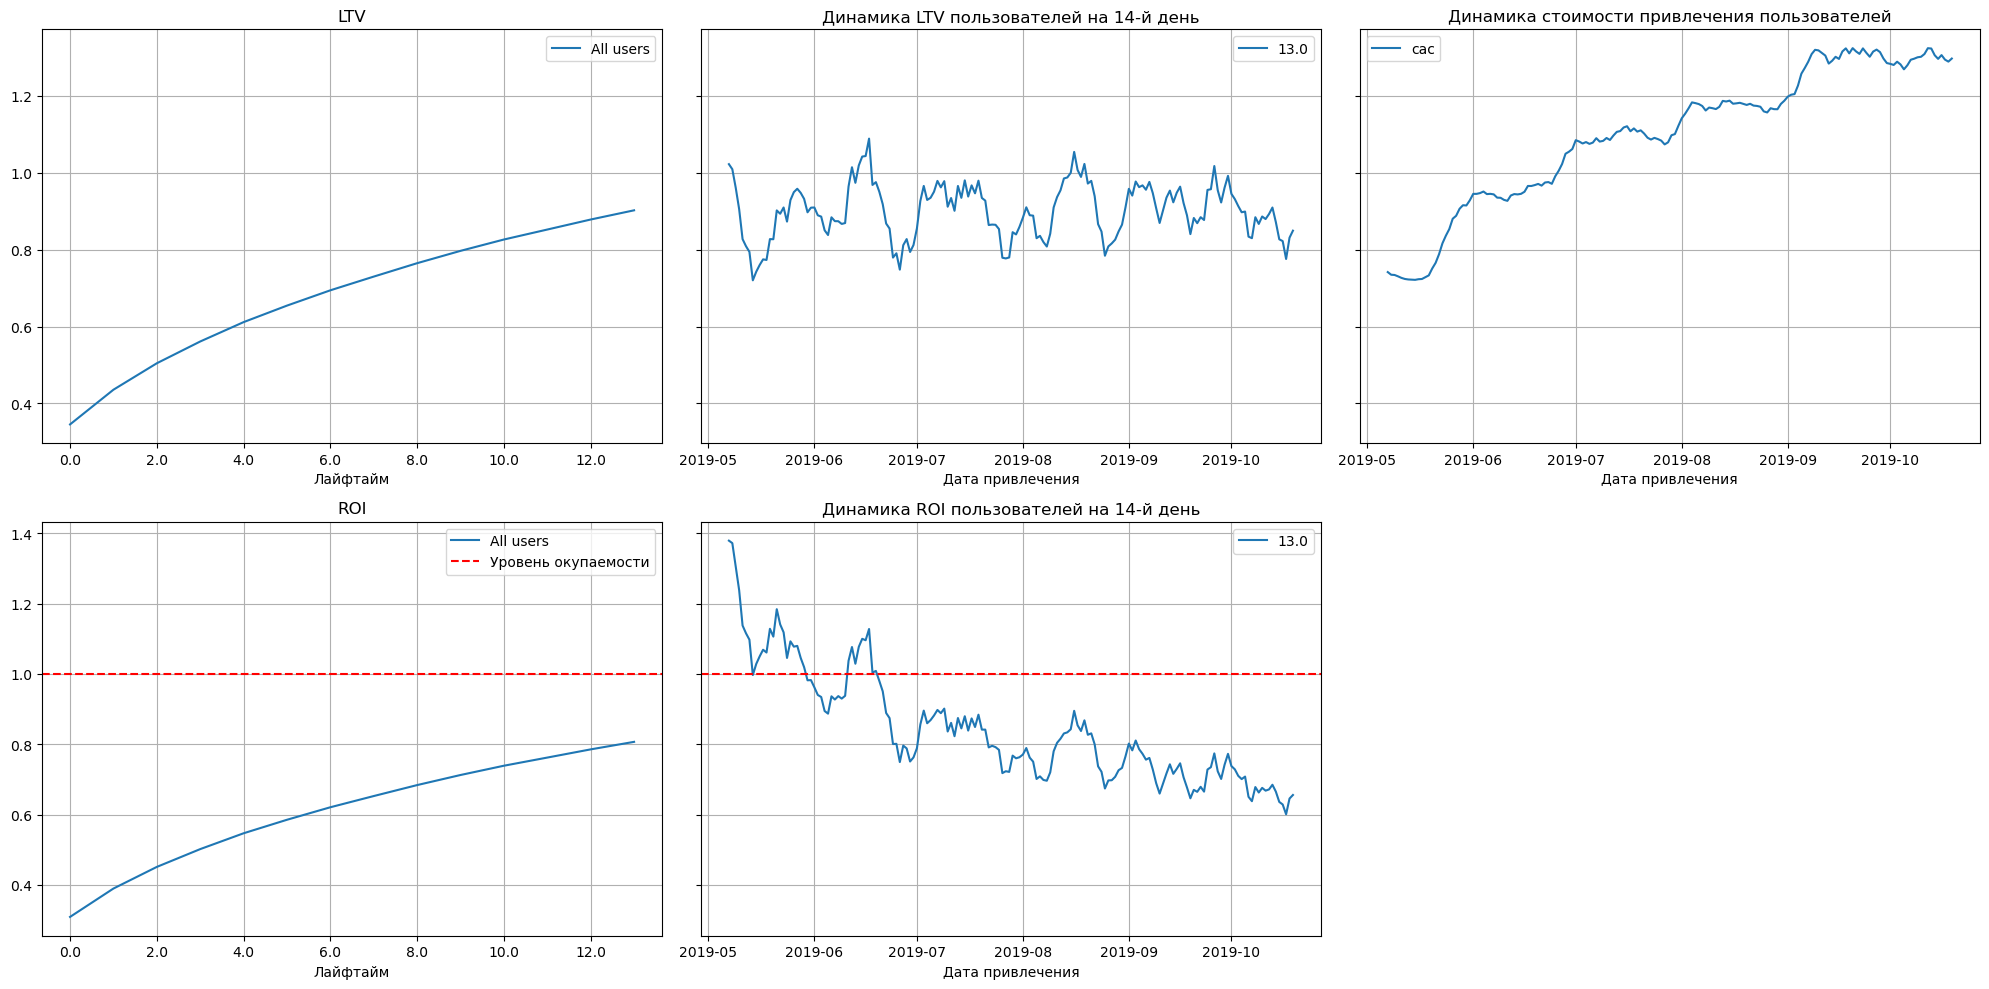

In [37]:
# отделим органических пользователей
profiles_without_organic = profiles[profiles.channel != 'organic']
observation_date = datetime(2019, 11, 1).date()
horizon = 14
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon)

В настоящее время наша реклама не окупается, это произошло из-за увеличения стоимости рекламы. Траты пользователей находятся в одном диапазоне.

#### Выполним проверку расчётов LTV и САС

In [38]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon
)

min_date = ltv_history.reset_index()['dt'].min()
max_date = ltv_history.reset_index()['dt'].max()

report = profiles.query(
    '@min_date <= dt <= @max_date'
)
assert len(report['user_id'].unique()) == ltv['cohort_size'].iloc[0], \
    'Сумма размеров когорт НЕ равна числу новых клиентов в изучаемый период.'

max_horizon = int(ltv_raw['lifetime'].max() + 1)
max_date_profiles = profiles['dt'].max()

# считаем LTV с максимальными горизонтом и моментом анализа
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, max_date_profiles, max_horizon, ignore_horizon=True
)

assert round(ltv.loc[
    'All users', max_horizon - 1
    ] * ltv.loc[
        'All users', 'cohort_size'
    ], 8) == orders['revenue'].sum(), \
    "Общая стоимость покупок новых клиентов" \
    "НЕ равна максимальному LTV, умноженному" \
    "на число новых клиентов."

max_acquisition_date = roi_history.reset_index()['dt'].max()

assert round(
    roi.loc[
        'All users', 'cac'
    ] * roi.loc[
        'All users', 'cohort_size'
    ], 7) == round(
    costs.query(
        'dt <= @max_acquisition_date'
    )['costs'].sum(), 7), \
    "CAC из таблицы ROI, умноженный на размер когорты," \
    "НЕ равен сумме рекламных трат за изучаемый период."

#### Чек-лист проверки
- [x] Сумма размеров когорт равна общему числу новых клиентов в изучаемый период.
- [x] Кривая LTV плавно растёт от нуля с возможным пересечением единицы.
- [x] Кривая LTV не снижается.
- [x] В таблице конверсии нет значений, превышающих единицу.
- [x] Общая стоимость покупок новых клиентов равна максимальному LTV, умноженному на число новых клиентов.
- [x] CAC из таблицы ROI, умноженный на размер когорты, равен сумме рекламных трат за изучаемый период.

#### Посмотрим на конверсию и удержание пользователей, а также отследим их динамику

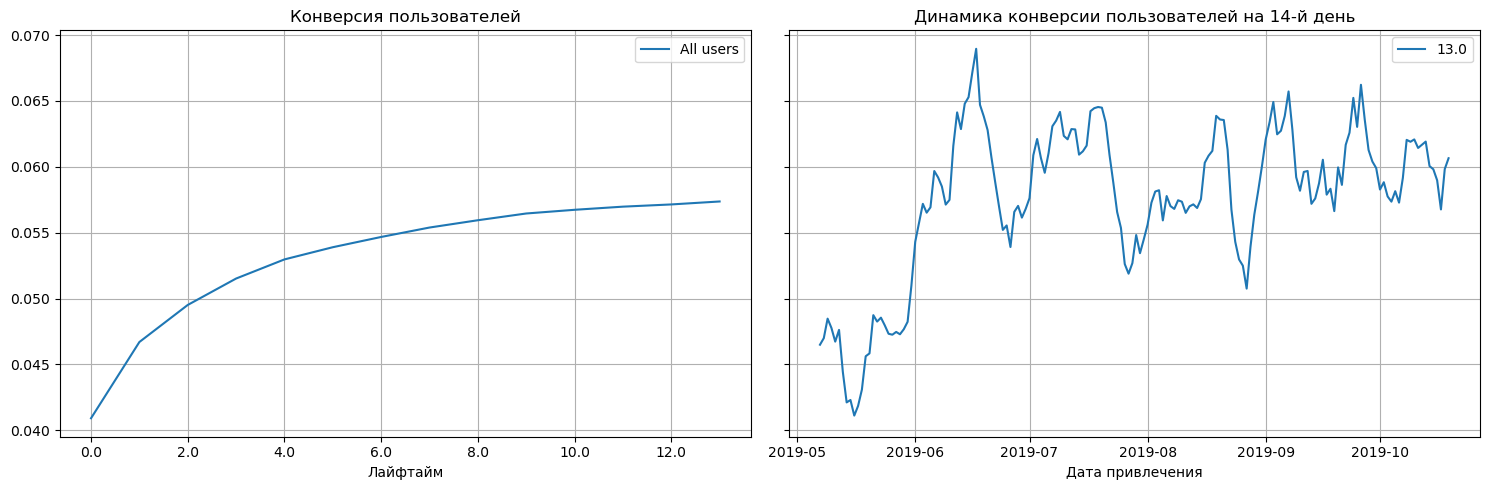

In [39]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon
)

plot_conversion(conversion_grouped, conversion_history, horizon)

Конверсия выходит на плато(более 5.5 %) в районе 14 дней, это значит что после 14 дней жизни вероятность конвертировать пользователя в платящего пользователя минимальна. В Мае конверсия увеличилась, а с июня по ноябрь находится стабильно в одном диапазоне.

#### Выполним проверку расчета Conversion rate

In [40]:
min_date = conversion_history.reset_index()['dt'].min()
max_date = conversion_history.reset_index()['dt'].max()

report = profiles.query(
    '@min_date <= dt <= @max_date'
)
assert len(report['user_id'].unique()) == conversion_grouped['cohort_size'].sum(), \
    'Сумма размеров когорт НЕ равна числу новых клиентов в изучаемый период.'

assert not (conversion_grouped.values[:, 1:] > 1).any()
assert not (conversion_history.values[:, 1:] > 1).any()

payer_uniq = (round(
    conversion_grouped['cohort_size'].iloc[0] * conversion_grouped[13].iloc[0], 8
))

report = orders.merge(
    profiles.query(
        '@min_date <= dt <= @max_date'
    ),
    on='user_id',
)

report['lifetime'] = (report['event_dt'] - report['first_ts']).dt.days
report = report.query('lifetime <= @horizon - 1')
assert payer_uniq == len(report['user_id'].unique())

#### Чек-лист проверки
- [x] Сумма размеров когорт равна общему числу новых клиентов в изучаемый период.
- [x] Кривая конверсии плавно растёт от нуля в направлении единицы.
- [x] Кривая конверсии не снижается.
- [x] В таблице конверсии нет значений, превышающих единицу.
- [x] Количество новых покупателей равно числу новых клиентов, умноженному на общую конверсию.

#### Посмотрим на конверсию в разрезе устройств

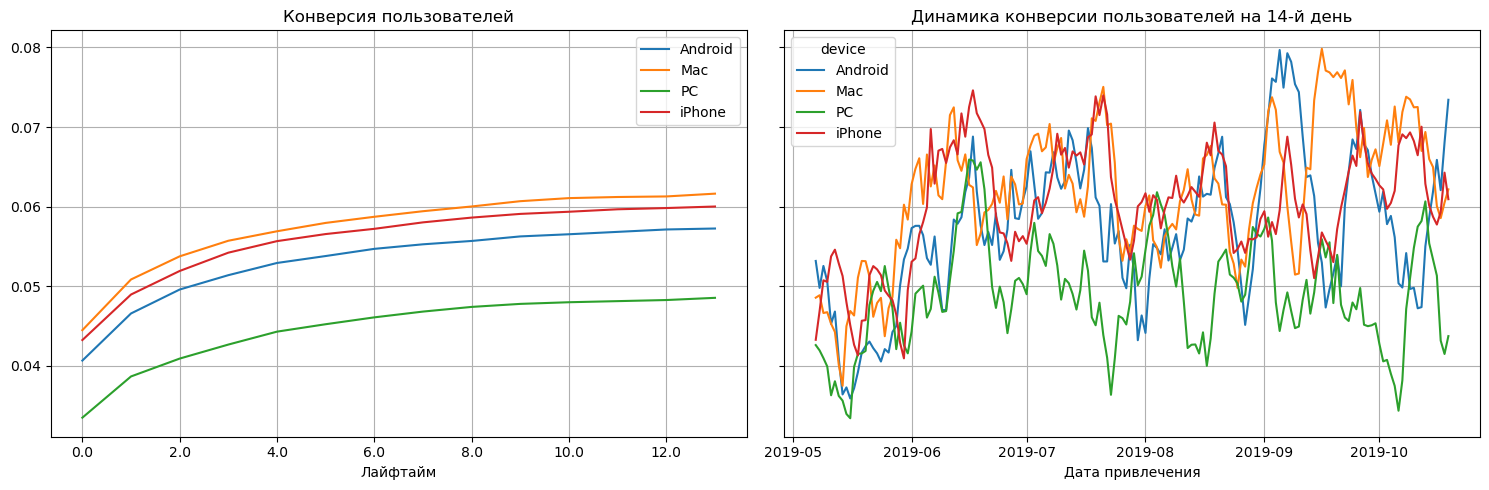

In [41]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon)

Конверсия на PC намного ниже, чем на других устройствах.

#### Посмотрим на конверсию в разрезе стран.

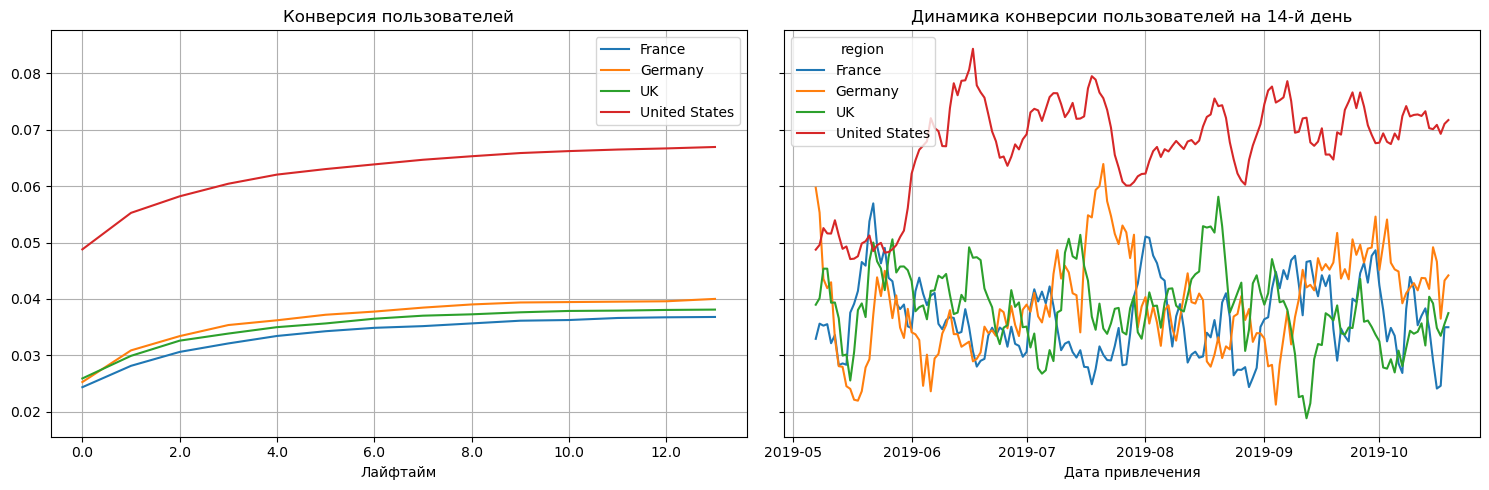

In [42]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon)

Конверсия пользователей в США, значительно выше чем в других странах.

#### Посмотрим на конверсию в разрезе каналов.

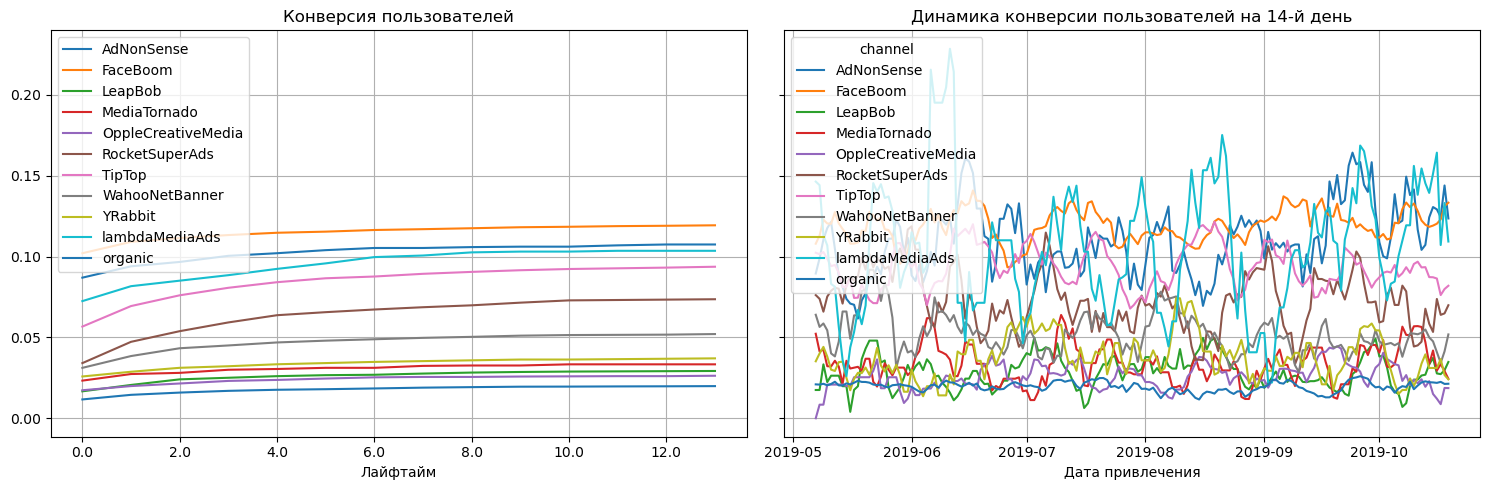

In [43]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon,
    dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon)

Среди каналов привлечения самой высокой конверсией обладают пользователи из FaceBoom, AdNonSense, LamdaMediaAds, TipTop. А самой низкой конверсией OppleCreativeMedia, LeapBob, YRabbit, MediaTornado.

#### Взглянем какая у нас ситуация с удержанием пользователя

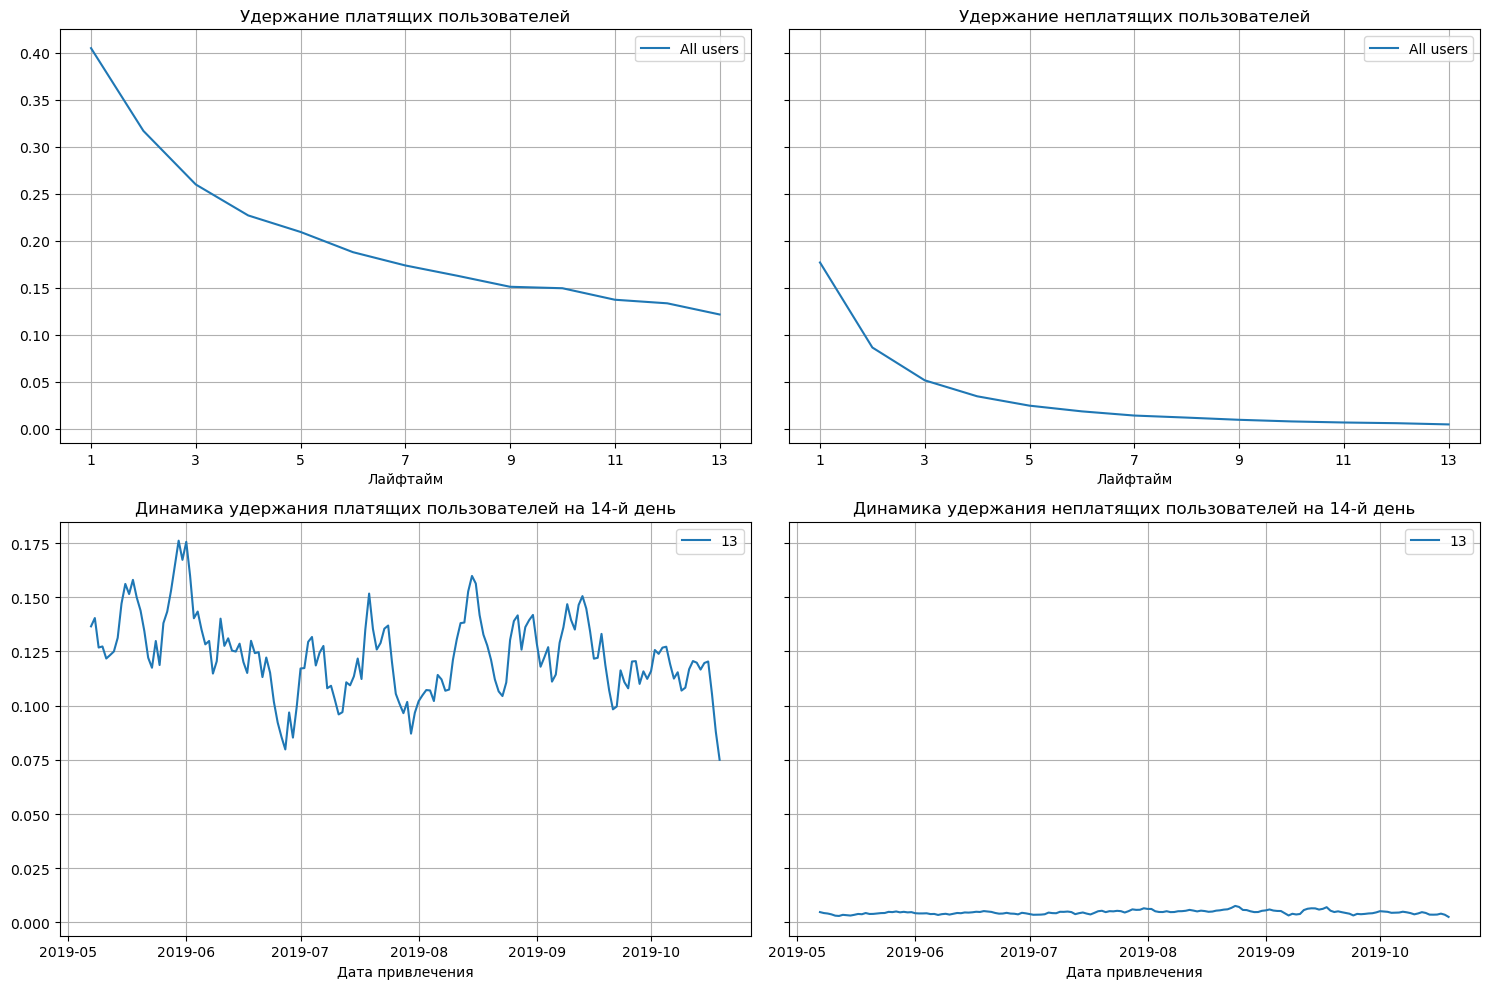

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon
)

plot_retention(retention_grouped, retention_history, horizon)

Заметим, что удержания платящих пользователей имеет тренд на снижение. Стоит задуматься, чем можно удержать клиента на более длительный срок.

#### Выполним проверку расчета Retention rate.

In [45]:
min_date = retention_history.reset_index()['dt'].min()
max_date = retention_history.reset_index()['dt'].max()

report = profiles.query(
    # в профилях находим платящих пользователей,
    # привлечённых с 1 мая по 19 октября
    '@min_date <= dt <= @max_date'
)

assert len(report['user_id'].unique()) == retention_grouped['cohort_size'].sum(), 'Сумма размеров когорт не равна числу новых клиентов в изучаемый период'

report = report.query('payer == True')
assert len(report['user_id'].unique()) == retention_grouped.query('payer == True')['cohort_size'].sum()

#### Чек-лист проверки
- [x] Сумма размеров платящих когорт равна числу покупателей в изучаемый.
- [x] Сумма размеров когорт равна числу новых клиентов в изучаемый период.<br>
- [x] Удержание убывает по экпоненциальному закону.
- [x] Удержание неплатящих убывает быстрее, чем удержание платящих.

#### Посмотрим на удержание в разрезе устройств

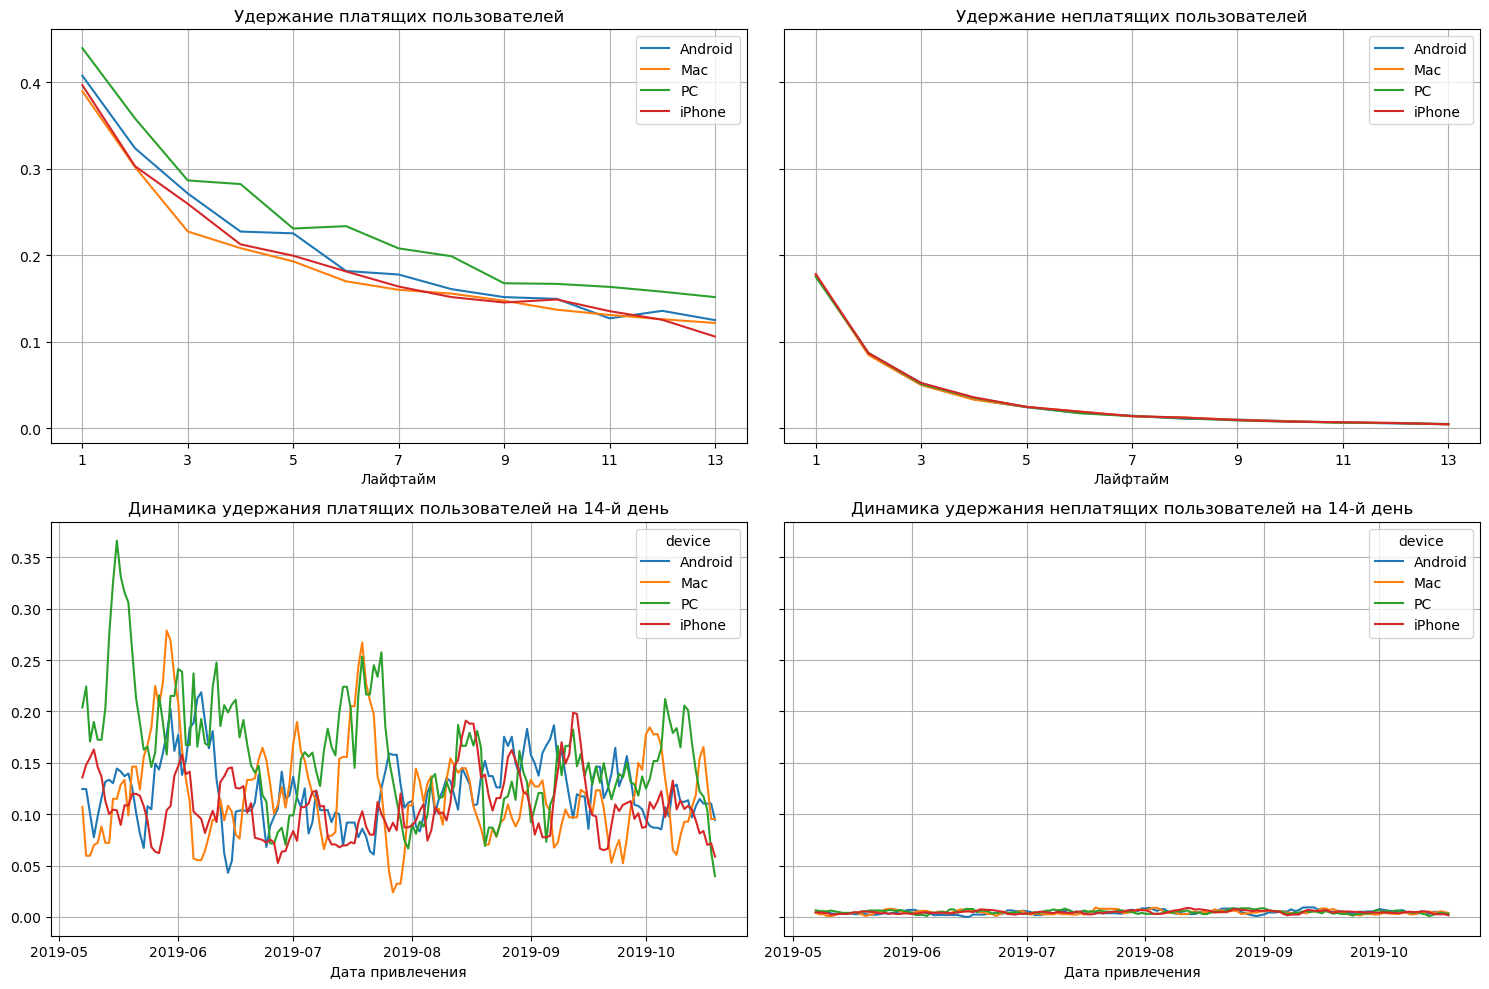

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon)

Удержание пользователей пользующихся PC немногим выше остальных, но в целом отрыв небольшой.

#### Посмотрим на удержание в разрезе стран.

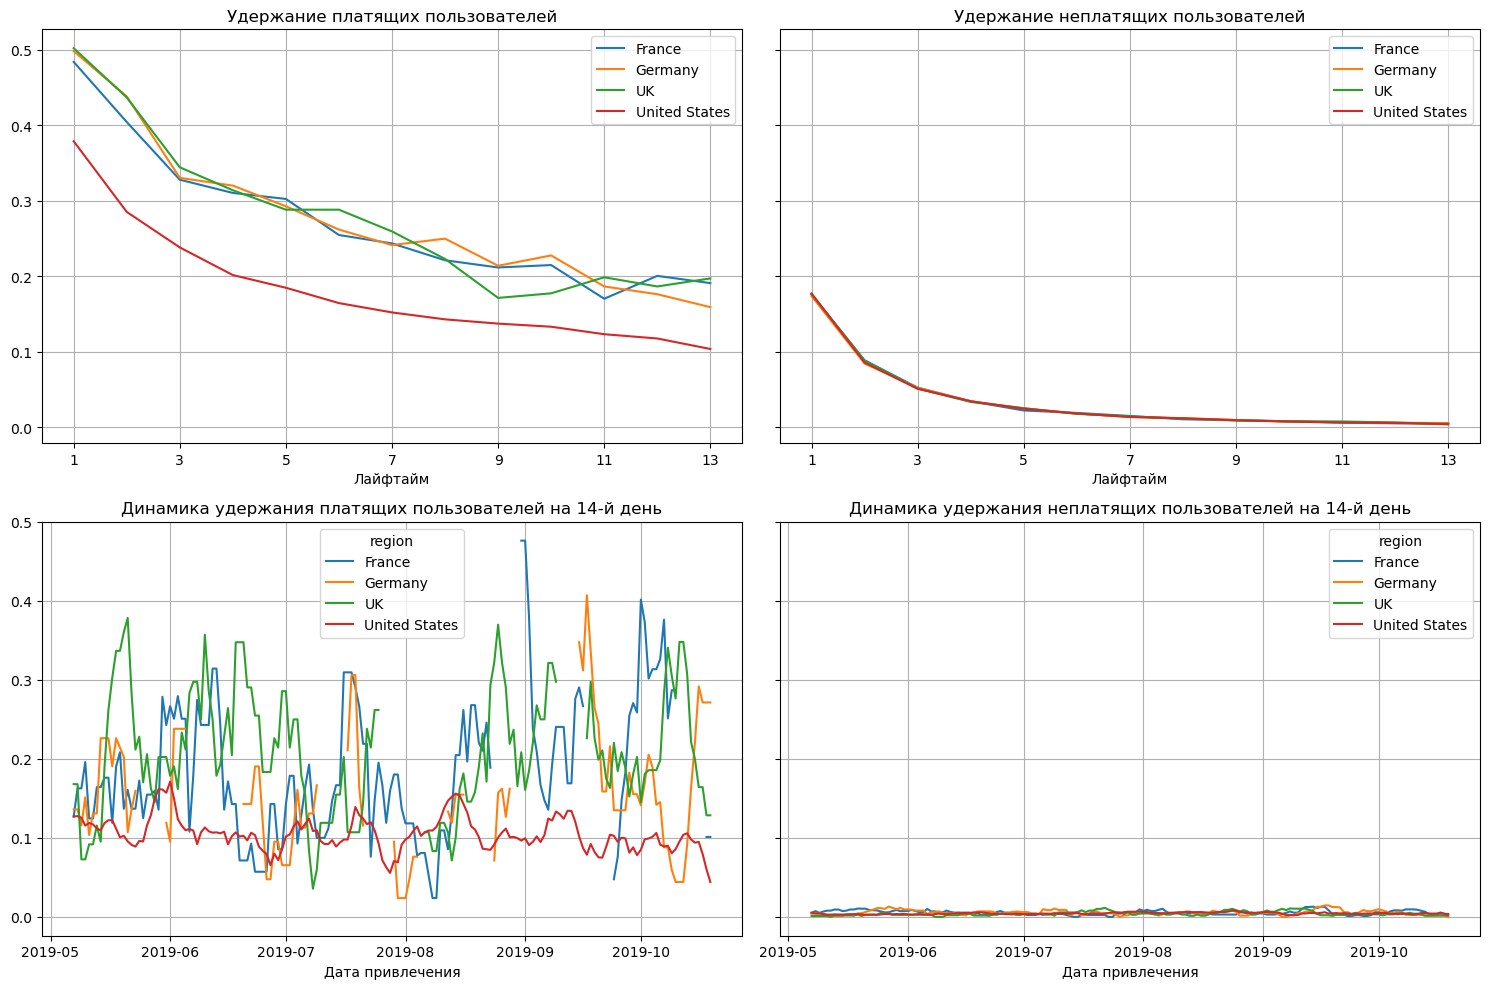

In [47]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon)

Видно, что удержание платящих пользователей в США страдает.

#### Посмотрим на удержание в разрезе каналов

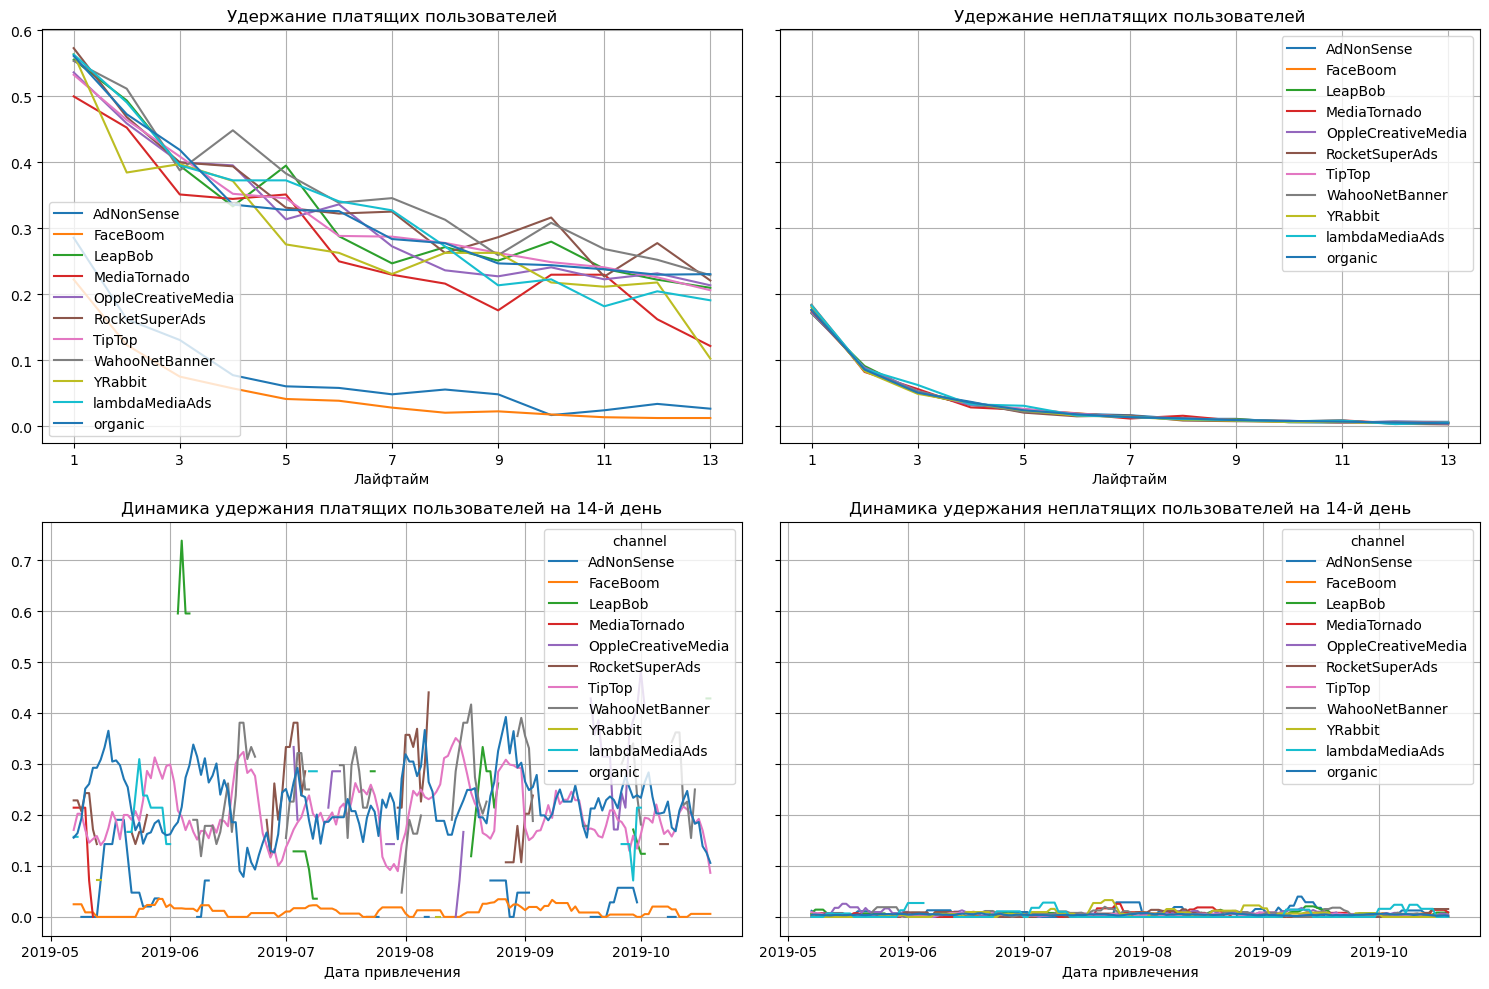

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon)

Тут у нас два явных оутсайдера - FaceBoom и AdNonSense

#### Посмотрим окупаемость рекламы с разбивкой по типам устройств

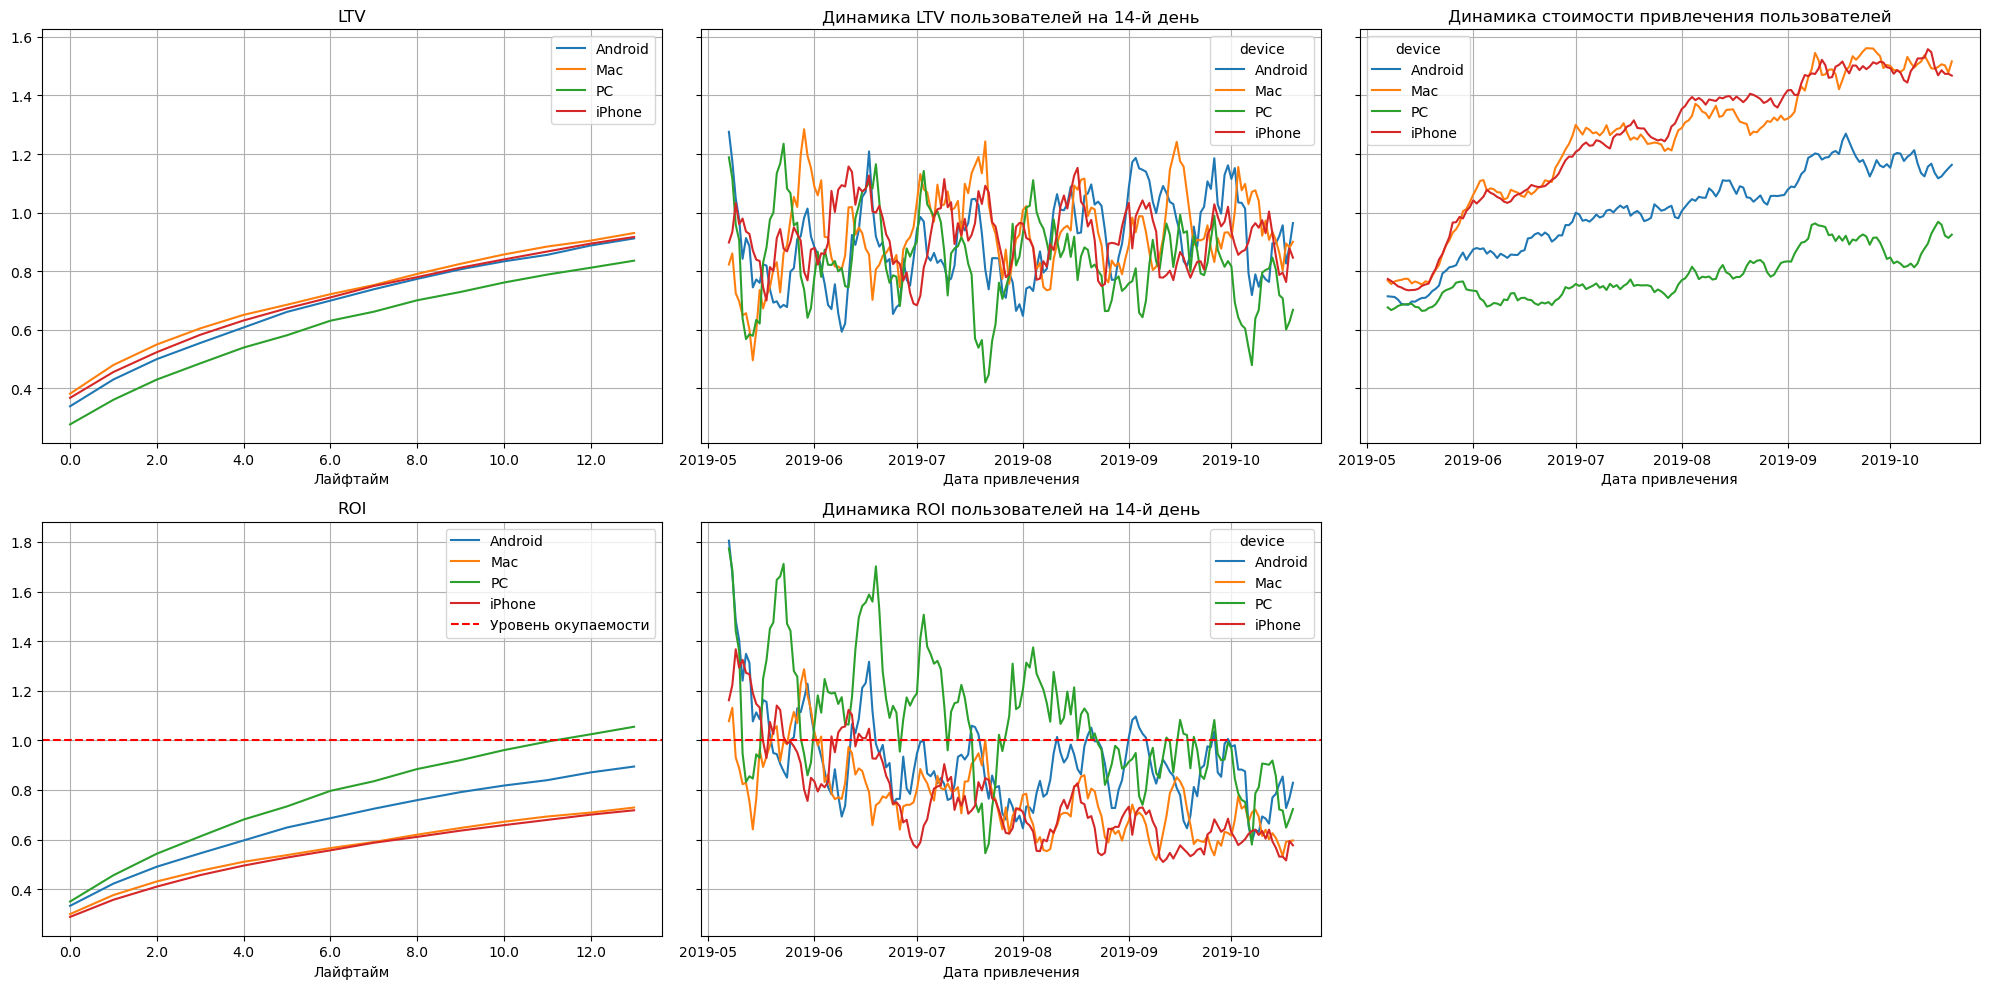

In [49]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon, dimensions=['device']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon)

Стоимость привлечения пользователей пользующихся техникой Apple обходится нам дороже чем привлечения пользователей Android и PC. LTV у пользователей всех устройств находится примерно на одном уровне. У пользователей PC LTV немногим ниже, чем у остальных пользователей, но за счет низкой стоимости привлечения, реклама окупается уже на 11 день жизни пользователя. Но с сентября перестают окупаться и пользователи на PC.

#### Посмотрим окупаемость рекламы с разбивкой по странам

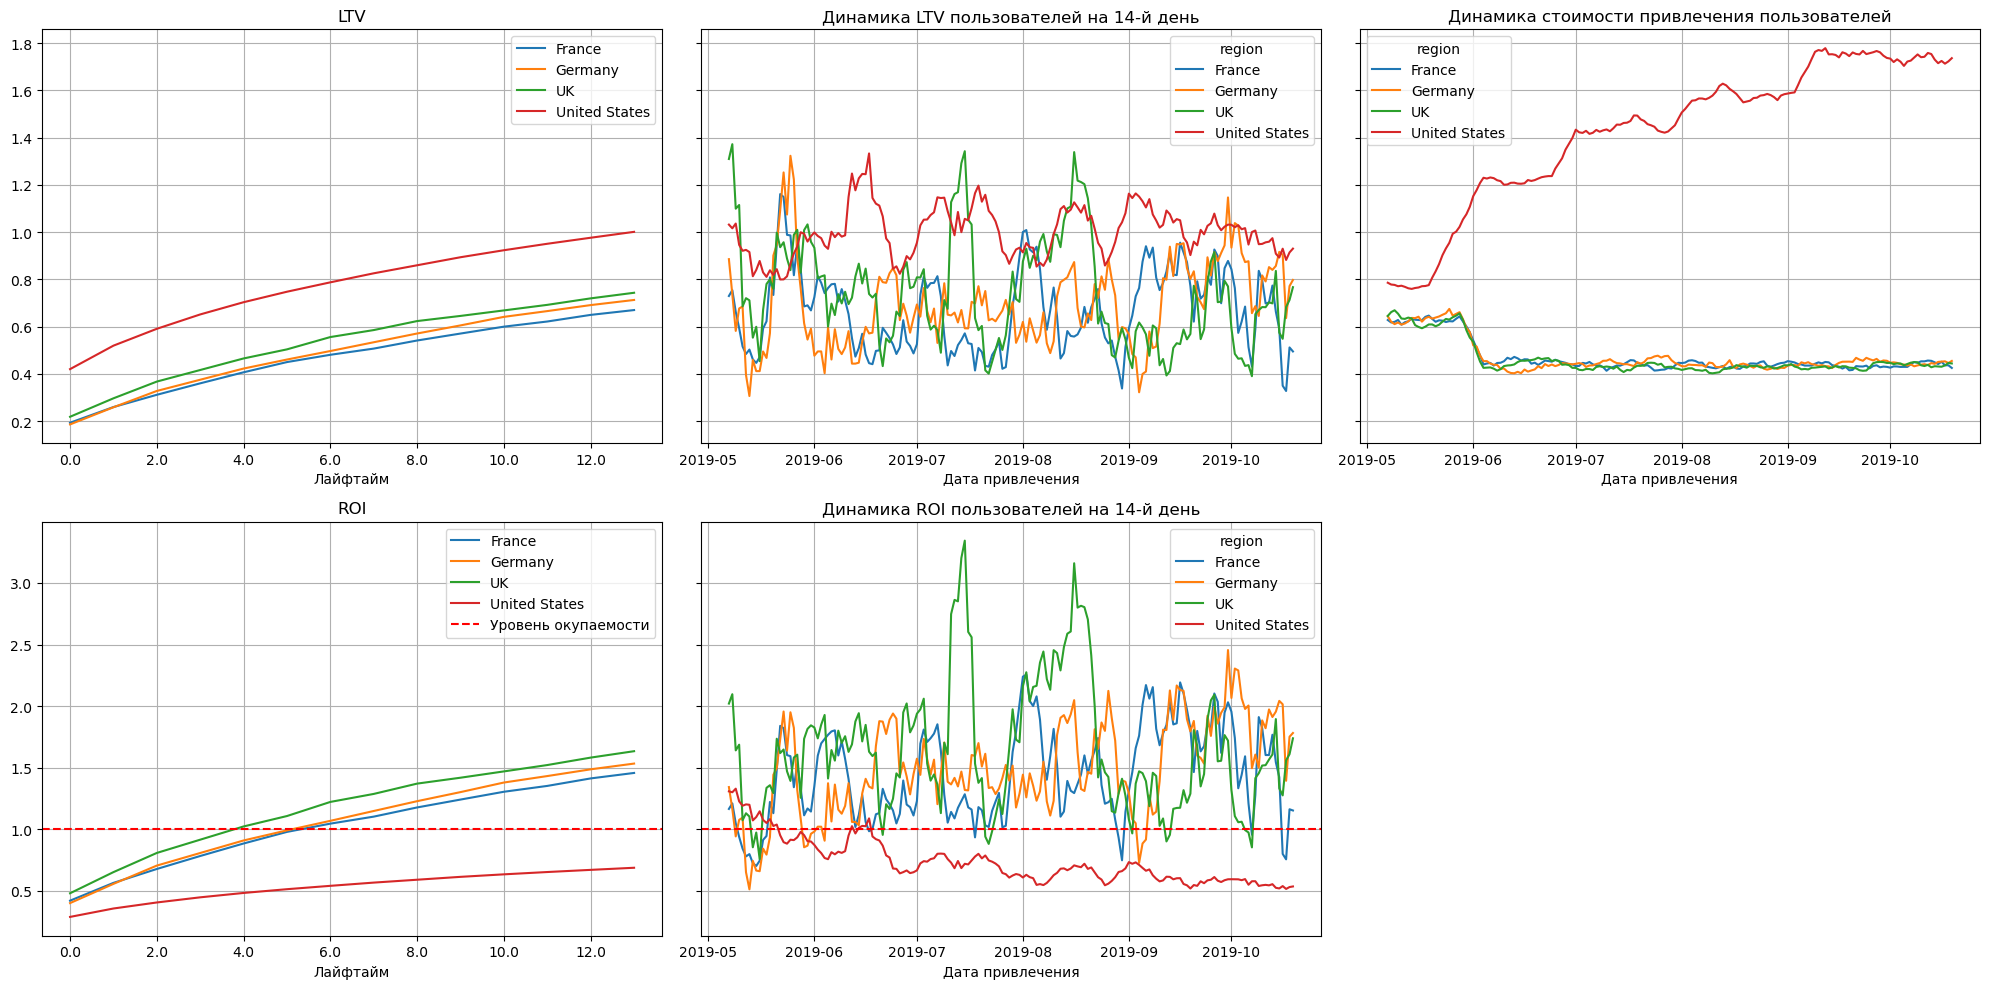

In [50]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon, dimensions=['region']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon)

Пользователи из США тратят на наше приложение немногим больше остальных пользователей, но за счет очень дорогих каналов привлечения этих пользователей они получаются убыточны для нас. Реклама в Европе напротив подешевела, и пользователи окупаются уже 4-5 день жизни.

#### Посмотрим окупаемость рекламы с разбивкой по рекламным каналам

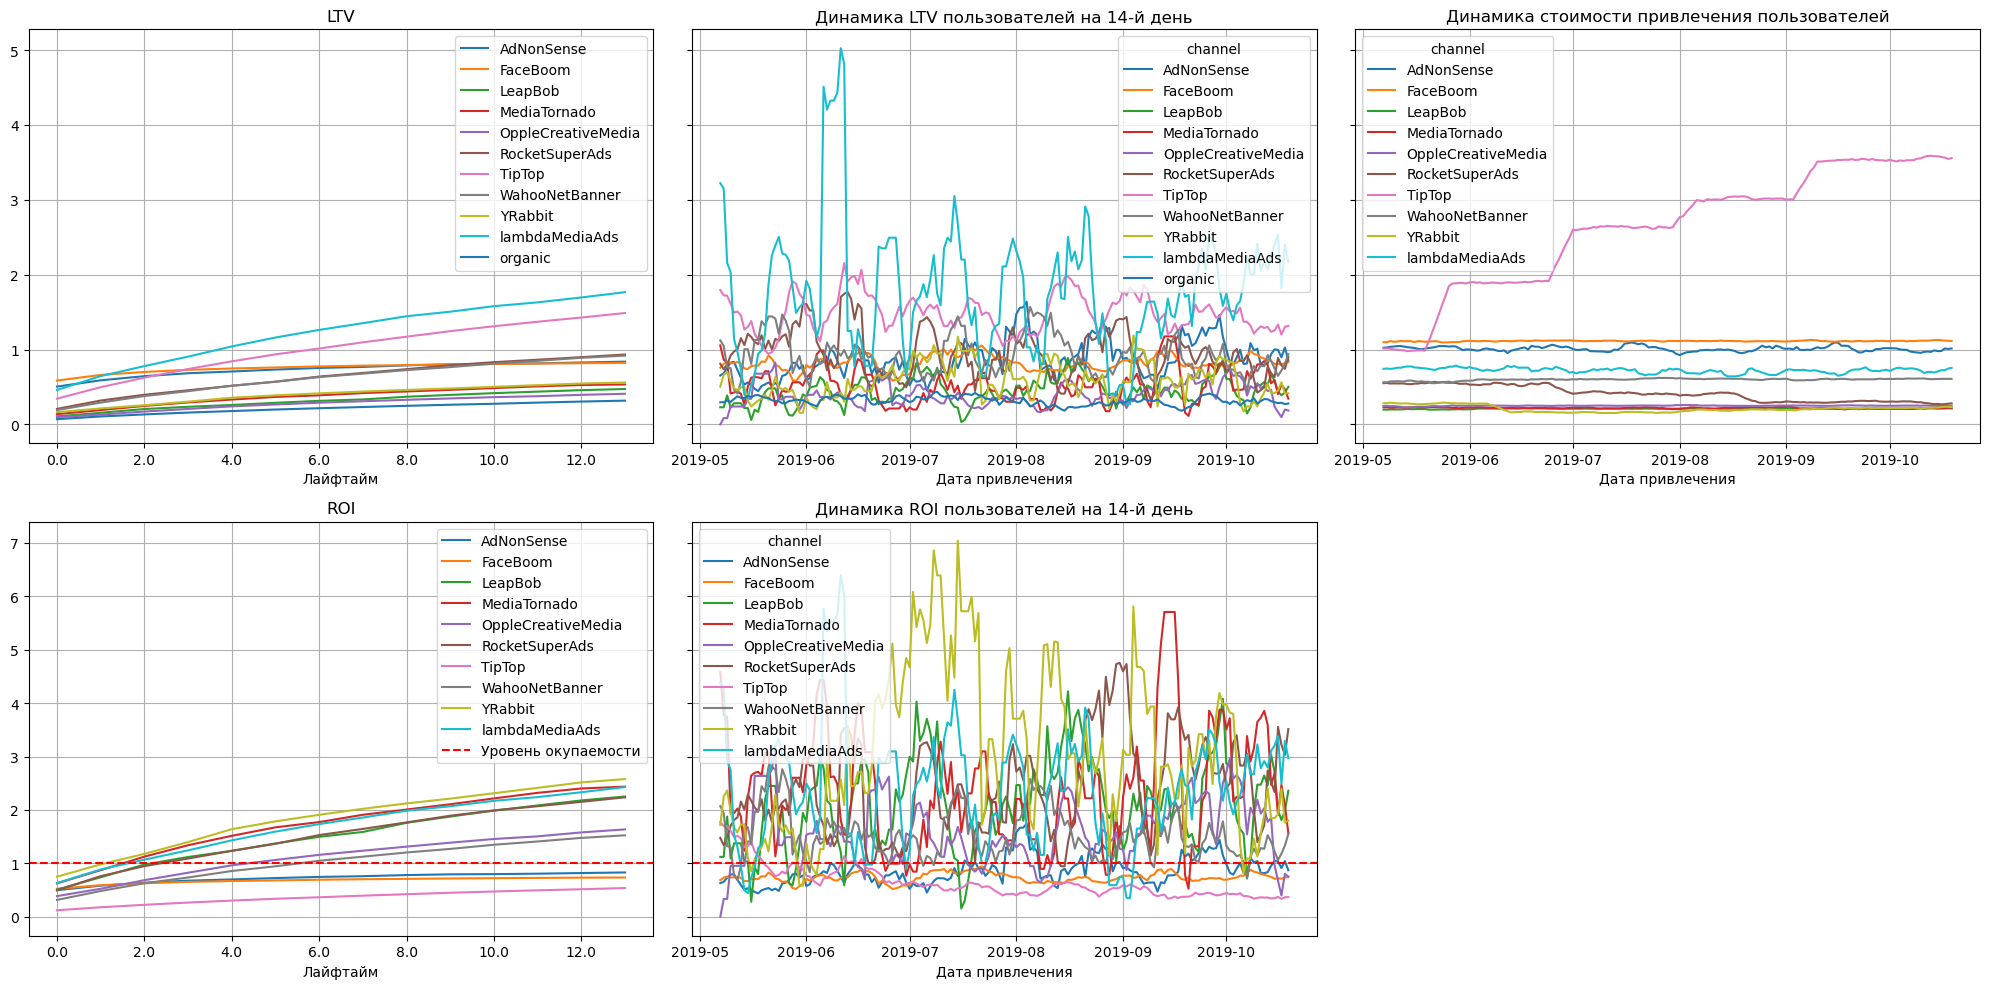

In [51]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon, dimensions=['channel']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon)

Для нас убыточны три канала привлечения пользователей - TipTop, FaceBoom, AdNonSense. Стоимость привлечения через TipTop выросла до неадекватных значений. Самыми выгодными каналами привлечения пользователей являются - YRabbit, MediaTornado, LambdaMediaAds, LeapBob, RocketSuperAds.

#### Посмотрим окупаемость рекламы с разбивкой по рекламным каналам в США

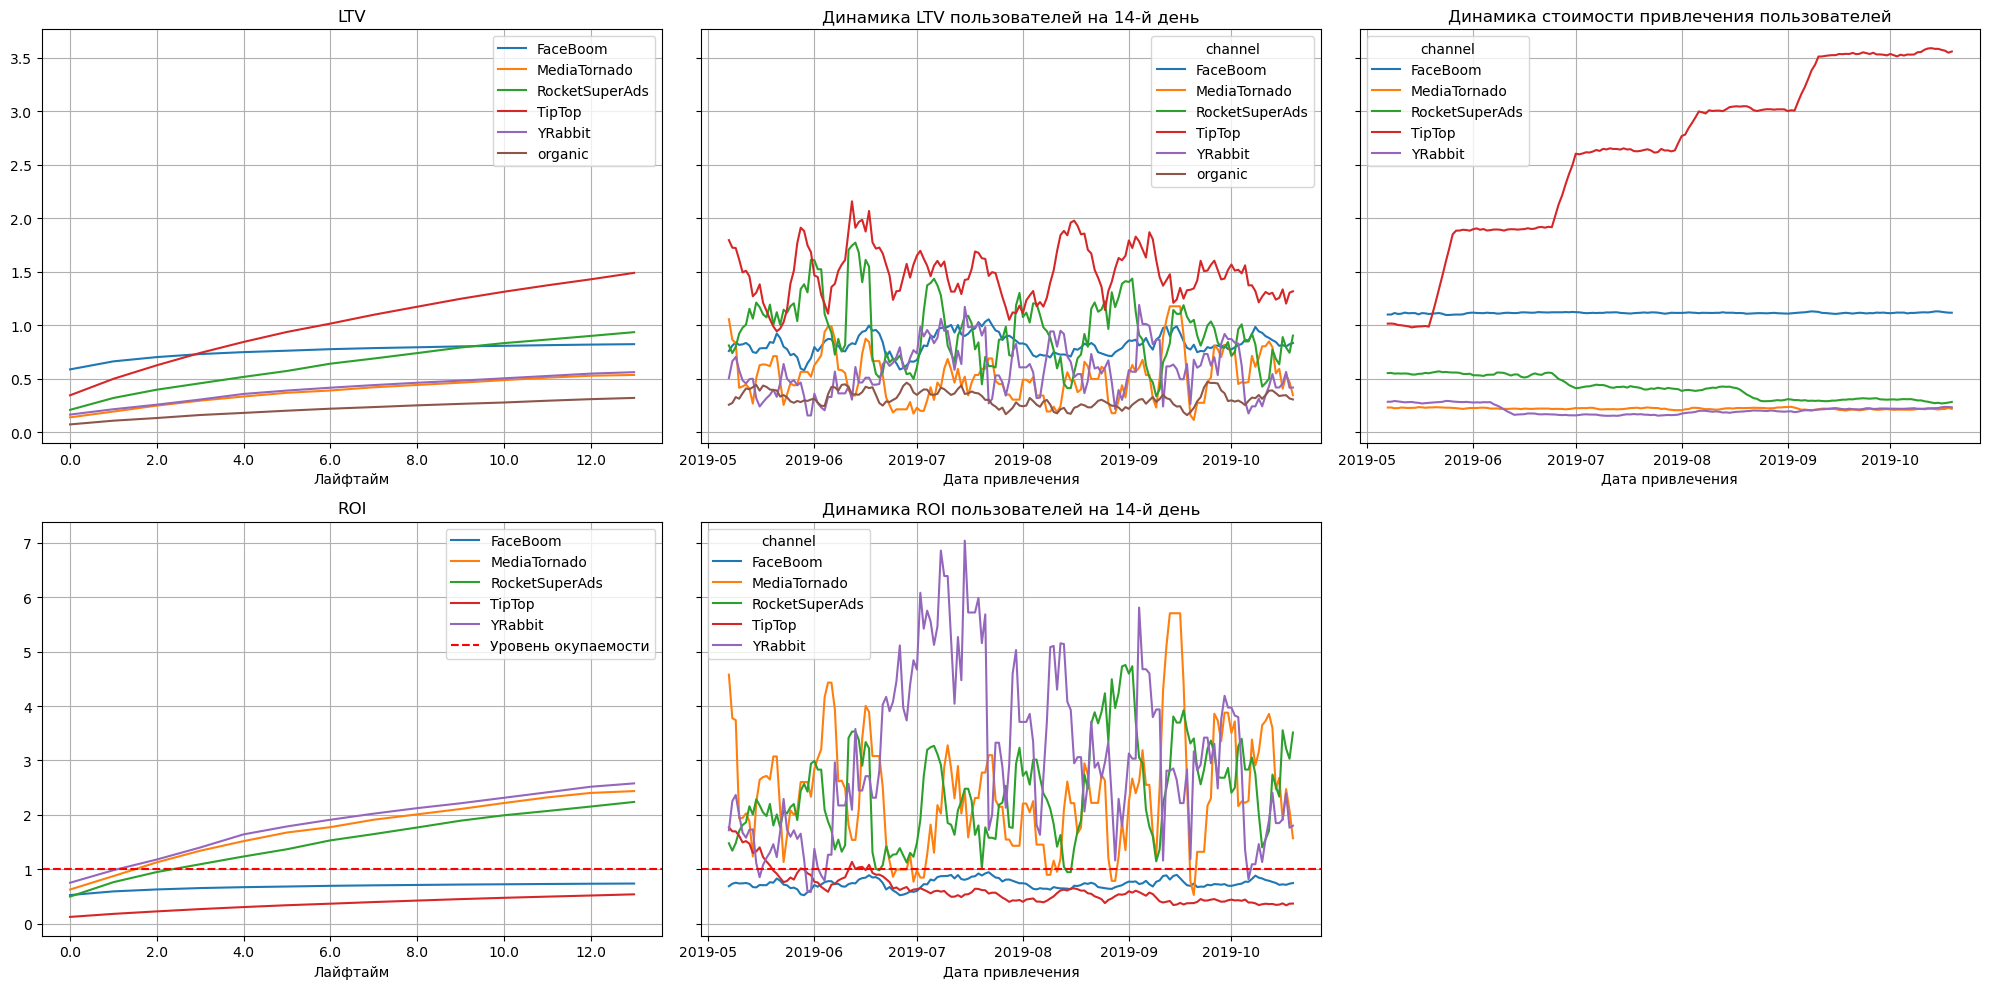

In [52]:
profiles_usa = profiles[profiles.region == 'United States']
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon, dimensions=['channel']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon)

Два наших убыточных канала, являются лидерами по привлечению клиентов в США, поэтому этот регион, по окупаемости рекламы, показывает себя с плохой стороны.

#### Посмотрим окупаемость рекламы с разбивкой по рекламным каналам в Европе

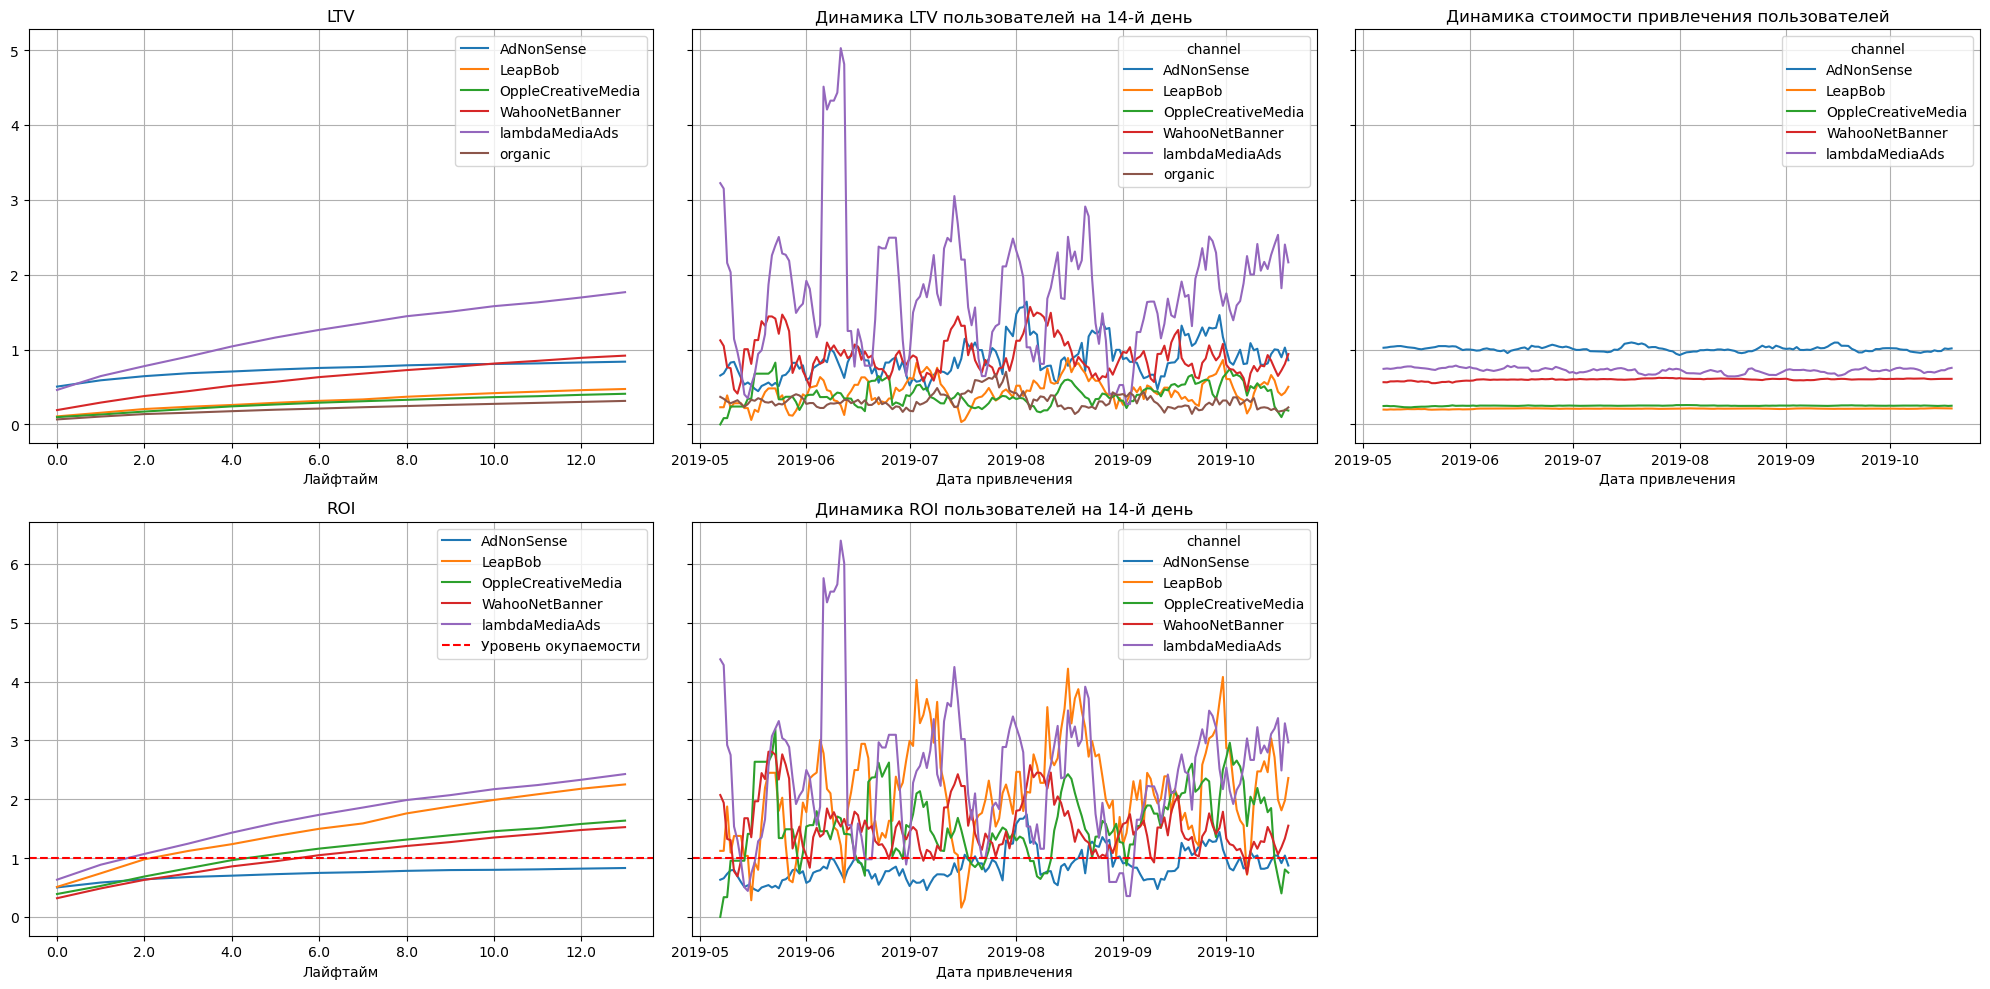

In [53]:
profiles_europe = profiles[profiles.region != 'United States']
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_europe, orders, observation_date, horizon, dimensions=['channel']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon)

В Европе ситуация с окупаемостью рекламы получше чем в США. Убыточным считается только один канал AdNonSense. Самыми экономически выгодными каналами являются LamdaMediaAds и LeapBob.

#### Вывод по окупаемости рекламы
- Реклама направленная на привлечение пользователей не окупается, расходы растут, а ROI снижается на протяжении всего рассматриваемого периода.
- Удержание платящих пользователей на 14 день имеет небольшой тренд на снижение, стоит задуматься как задержать пользователя на более длительный срок.
- Удержание пользователей из США намного хуже, чем из Европы. Также удержание у пользоватлей привлеченных через канал FaceBoom очень низкое.
- Во все регионах кроме США реклама окупается на 4-5 день жизни. В США реклама убыточна.
- Для нас убыточны три канала привлечения пользователей - TipTop, FaceBoom, AdNonSense.
- Стоит кардинально поменять рекламную политику компании в США. Стоит обратить внимание на более экономически выгодные каналы, такие как YRabbit, MediaTornado, RocketSuperAds.

<a id="conclusion"></a>
### Общий вывод по США:
- Конверсия в США ниже чем в Европе, виной этому канал FaceBoom, пользователи, которых он привлекает, надолго не задерживаются в нашем приложении.
- LTV у клиентов из США выше, чем у клиентов из Европы, но несмотря на это из-за огромной стоимости привлечения клиентов, реклама в этом регионе убыточна. 
- FaceBoom и TipTop несмотря на высокую конверсию являются убыточными для нас.
### Общий вывод по Европе:
- В Европе ситуация получше, средства потраченные на рекламу окупаются, но стоит обратить внимание на канал AdNonSense. Удержание пользователей привлеченных через этот канал на низком уровне.
#### Рекомендации 
- В США обратить внимание на RocketSuperAds.Этот канал привлечения клиентов с высокой конверсией и не высокой ценой привлечения клиентов. А рекламные расходы на такие каналы как FaceBoom и TipTop сократить до минимума, либо вообще отказаться от них.
- В Европе обратить внимание на LamdaMediaAds. Этот канал с высокой конверсией и самой высокой окупаемостью рекламы в Европе. Отказаться от сотрудничества с каналом AdNonSense, для нас этот канал убыточен.
- Очень слабая конверсия у пользователей на PC, может говорить каких-то проблемах на этих устройствах.

[В начало](#start)